# Minimax with autoencoder

In [2]:
from collections import OrderedDict

import pandas as pd
#import uproot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
import random
import torch.autograd as autograd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics
import h5py
import torch.nn.functional as F

import torch.distributions.multivariate_normal as mn
import math
import pickle

import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf

random_seed = 99
torch.manual_seed(random_seed)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else "cpu")

In [3]:
pulses = pickle.load(open('/Users/nzaretski/Desktop/gerda/CNN_GAN_Ge/data/raw/data.pkl','rb'))
pulses = pulses.astype(float)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pulses = scaler.fit_transform(pulses)

import pickle
pickle.dump(scaler, open('scaler.pkl','wb'))

In [5]:
train_data_length = pulses.shape[0]
train_data = torch.zeros((train_data_length, 3748))
train_data = torch.tensor(pulses, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [6]:
batch_size = 128

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

## 1. Models

In [8]:
#epochs = 500
lr = 1e-4
#autoenc
seq_len = 5000
emb_dim = seq_len // 16
#wgan
hidden_dim = 8
latent_dims = 32 


In [11]:
class Encoder(nn.Module):   ## changed
    def __init__(self):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 8, self.emb_dim, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [13]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.emb_dim, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False),
      )


    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)  
        return output.squeeze(-1)

In [14]:
class Discriminator(nn.Module):   ## changed
    def __init__(self):
        super(Discriminator, self).__init__()
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.emb_dim, self.emb_dim // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 2, self.emb_dim // 4, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 4, self.emb_dim // 8, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 8, 1, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_len = emb_dim
        self.emb_dim = latent_dims
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.emb_dim, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False),
      )


    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)  
        return output.squeeze(-1)

# Autoencoder

In [22]:
epochs_autoen = 50

In [23]:
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)
recon_loss = nn.MSELoss(reduction = 'sum').to(DEVICE)

In [27]:
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=1e-3)

In [26]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
losses = []
for epoch in range(epochs_autoen):
    for i, (x, y) in enumerate(train_loader):
        x = x.to(DEVICE)
        z = encoder(x)
        x_hat = decoder(z)
        loss = recon_loss(x, x_hat)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(x), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))       
        losses.append(loss.item())
torch.save(decoder.state_dict(), 'decoder.pth')

Train Epoch: 0 [0/2619 (0%)]	Loss: 200138.218750
Train Epoch: 1 [0/2619 (0%)]	Loss: 84142.679688
Train Epoch: 2 [0/2619 (0%)]	Loss: 68891.843750
Train Epoch: 3 [0/2619 (0%)]	Loss: 54553.054688
Train Epoch: 4 [0/2619 (0%)]	Loss: 29515.617188
Train Epoch: 5 [0/2619 (0%)]	Loss: 21907.824219
Train Epoch: 6 [0/2619 (0%)]	Loss: 65322.453125
Train Epoch: 7 [0/2619 (0%)]	Loss: 81982.234375
Train Epoch: 8 [0/2619 (0%)]	Loss: 38470.339844
Train Epoch: 9 [0/2619 (0%)]	Loss: 23323.515625
Train Epoch: 10 [0/2619 (0%)]	Loss: 25118.099609
Train Epoch: 11 [0/2619 (0%)]	Loss: 93835.187500
Train Epoch: 12 [0/2619 (0%)]	Loss: 16128.142578
Train Epoch: 13 [0/2619 (0%)]	Loss: 106505.265625
Train Epoch: 14 [0/2619 (0%)]	Loss: 19891.304688
Train Epoch: 15 [0/2619 (0%)]	Loss: 49520.355469
Train Epoch: 16 [0/2619 (0%)]	Loss: 14584.189453
Train Epoch: 17 [0/2619 (0%)]	Loss: 22912.023438
Train Epoch: 18 [0/2619 (0%)]	Loss: 66637.625000
Train Epoch: 19 [0/2619 (0%)]	Loss: 24902.925781
Train Epoch: 20 [0/2619 (0%)

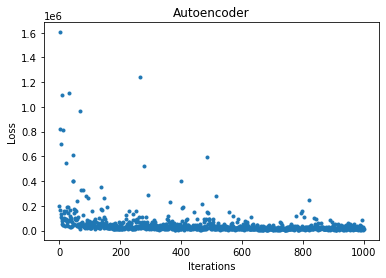

In [28]:
fig = plt.figure()
plt.plot(losses, '.')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Autoencoder")
fig.savefig('Auto_losses.png')

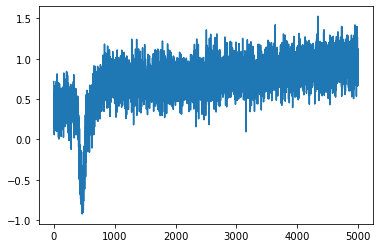

In [29]:
fixed_noise = torch.rand(128, emb_dim) 
with torch.no_grad(): #??
    fixed_noisev = fixed_noise.to(DEVICE)
plt.plot(decoder(fixed_noisev).cpu().detach()[0])

# Minimax


In [30]:
netD = Discriminator().to(DEVICE)
netG = Generator().to(DEVICE)
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

In [31]:
epochs = 100

In [32]:
random_dim = latent_dims
G_losses = []
D_losses = []
import time
start_time = time.time()

for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        x = x.to(DEVICE)
        x = encoder(x)
        real_samples_labels = torch.ones((batch_size, 1))
        real_samples_labels = real_samples_labels.to(DEVICE)
        
        latent_space_samples = torch.randn((batch_size, random_dim))
        latent_space_samples = latent_space_samples.to(DEVICE)
        
        generated_samples = netG(latent_space_samples)
        
        generated_samples_labels = torch.zeros((batch_size, 1))
        generated_samples_labels = generated_samples_labels.to(DEVICE)
        
        all_samples = torch.cat((x, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        ## training the discriminator
        netD.zero_grad()
        output_discriminator = netD(all_samples)
        
        errD = criterion(output_discriminator, all_samples_labels)
        errD.backward()
        optimizerD.step()
        
        ## training the generator
        latent_space_samples = torch.randn(batch_size, random_dim)
        latent_space_samples = latent_space_samples.to(DEVICE)
        netG.zero_grad()
        generated_samples = netG(latent_space_samples)
        outputDG = netD(generated_samples)
        errG = criterion(outputDG, real_samples_labels) #########
        errG.backward()
        optimizerG.step()
        
        G_losses.append(errG.item()) 
        D_losses.append(errD.item())
    
        
        if (epoch % 5 == 0 and i == batch_size - 1):
                print(f"Epoch{epoch} Loss D.: {errD}" "||" 
                  f"Loss G.: {errG}")
                
    if (epoch == 0):
        print(round(time.time() - start_time, 2), ' seconds')
    
    if (epoch % 50 == 0) and (epoch > 0):
        torch.save(netG.state_dict(), 'gen' +str(epoch) + '.pth')
        torch.save(netD.state_dict(), 'discr' +str(epoch) + '.pth')   
        

2.75  seconds


In [33]:
torch.save(netG.state_dict(), 'minimax_auto.pth')

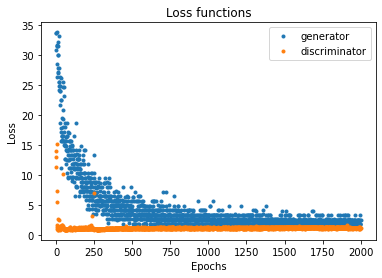

In [34]:
fig = plt.figure()
plt.plot(G_losses, '.', label='generator')
plt.plot(D_losses, '.',  label='discriminator')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

In [ ]:
## Check

In [40]:
x = torch.randn(10, random_dim).to(DEVICE)

In [41]:
noise = netG(x)

In [49]:
a = decoder(noise).detach().cpu()

In [50]:
a.shape

torch.Size([10, 5000])

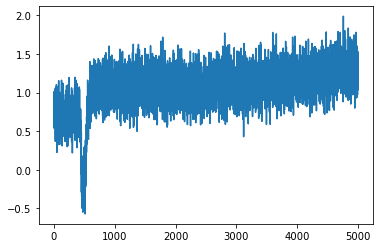

In [51]:
plt.plot(a[0])

In [ ]:
############